## Statistics of Tropical Cyclones (TCs) wind fields derived from Synthetic Aperture Radar (SAR) imagery
Dataset of 341 SAR files stored in .zarr format


In [12]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
import zarr
from scipy.interpolate import griddata
from datetime import datetime

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)

In [2]:
### TODO: Google Cloud data access and opening

### PATHS
dir_path = '/home/arthur/data/cyclobs/centered_rotated_files_06012022/clean_dataset/zarr_data/'
filename = 'tc_sar_data.zarr'

### OPEN FILES
ds_all = xr.open_zarr(dir_path + filename)

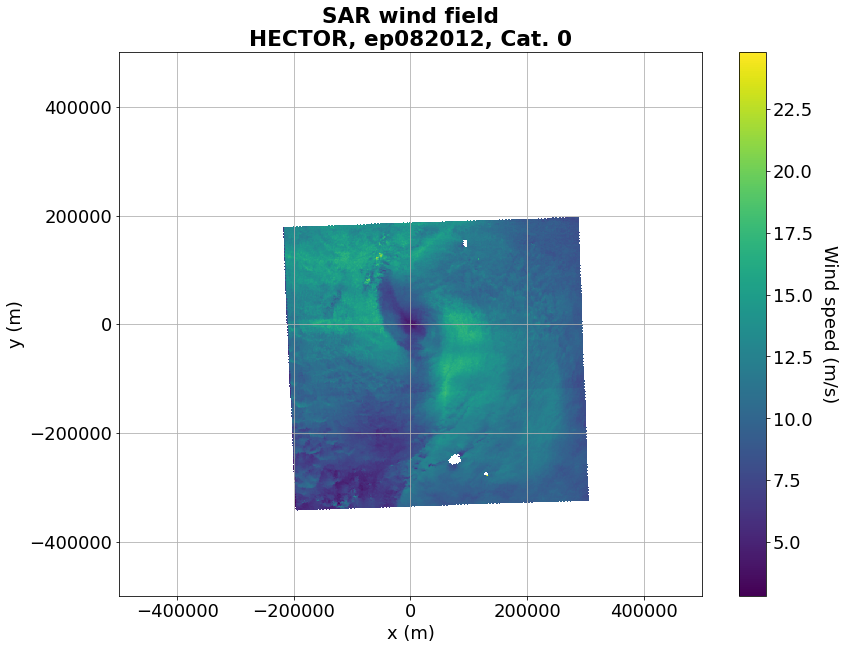

In [3]:
### PLOTTING WIND FIELDS
def plot_wind_field(ds_all, time_idx):
    # Open figure
    fig, _ = plt.subplots()
    
    # Title
    name = ds_all.isel(time=time_idx)['storm_name'].values
    tcId = ds_all.isel(time=time_idx)['storm_id'].values
    cat  = int(ds_all.isel(time=time_idx)['cat'])
    plt.title('SAR wind field\n%s, %s, Cat. %i'%(name, tcId, cat), weight='bold')
    
    # Plot
    x, y = np.meshgrid(ds_all.isel(time=time_idx)['x'], ds_all.isel(time=time_idx)['y']) # Defining 2D coordinates
    plt.pcolormesh(x, y, ds_all.isel(time=time_idx)['wind_speed'])                       # Plot the wind field
    plt.xlabel('x (m)');plt.ylabel('y (m)');plt.grid()                                 # Add axis legend
    plt.subplots_adjust(right=0.8)                                                       # Colorbar - line 1
    cbar = plt.colorbar()                                                                # Colorbar - line 2
    cbar.set_label('Wind speed (m/s)', rotation=270);cbar.ax.get_yaxis().labelpad=25     # Colorbar - line 3
    
plot_wind_field(ds_all, time_idx=0)

Indexes for HECTOR:  [  0  85  86  87 154 155 269 270]


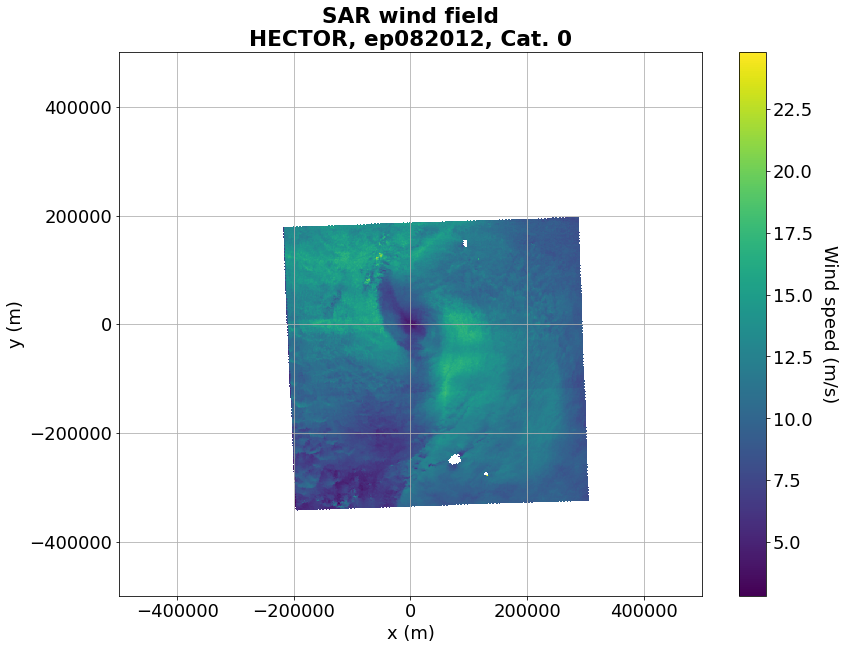

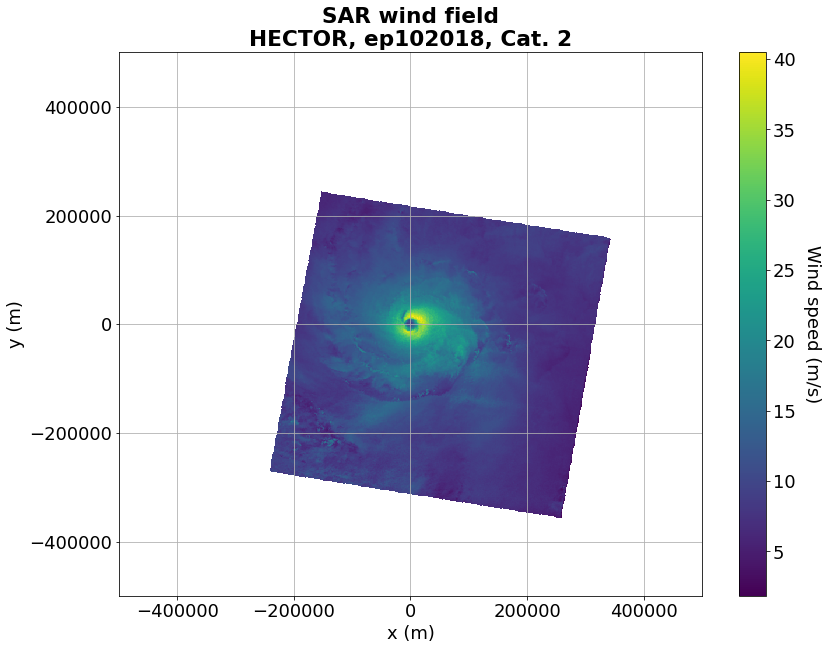

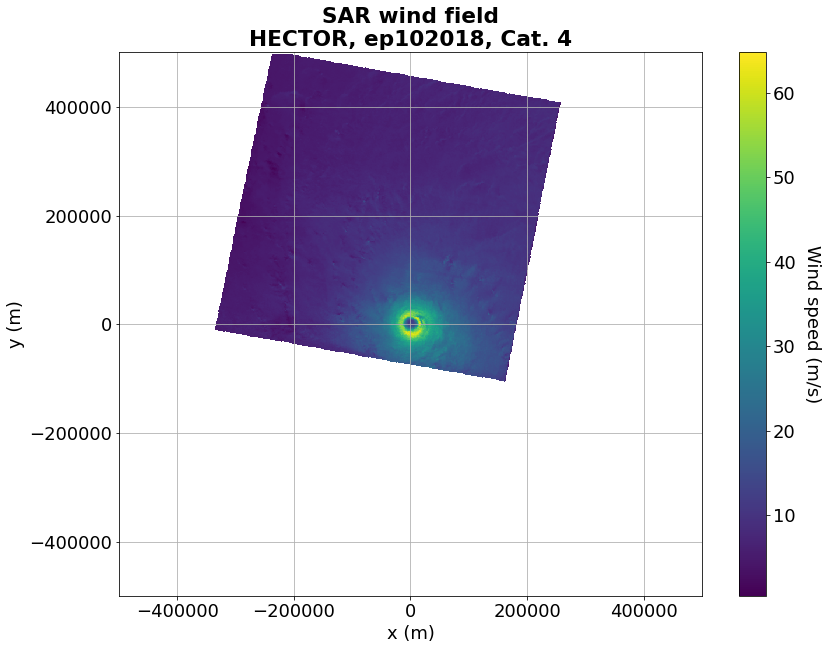

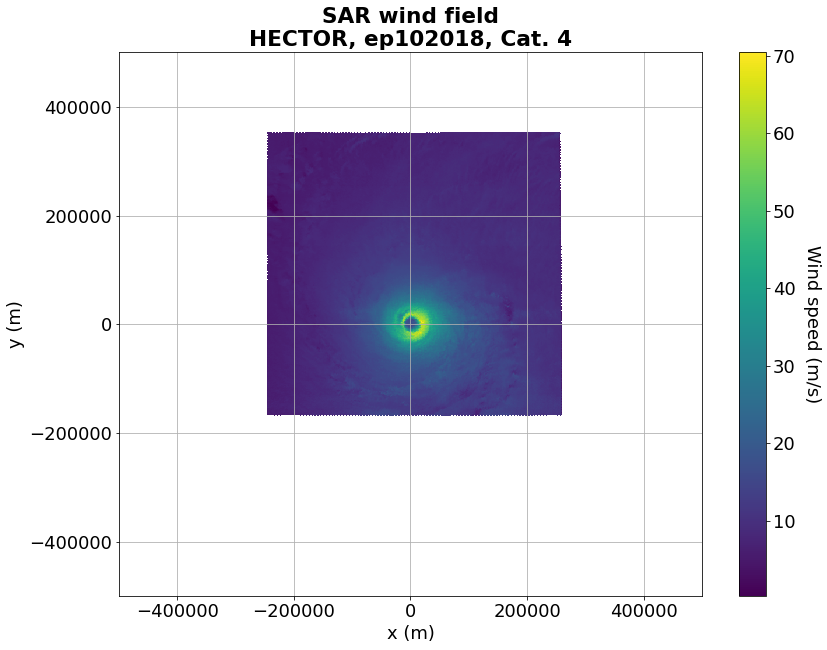

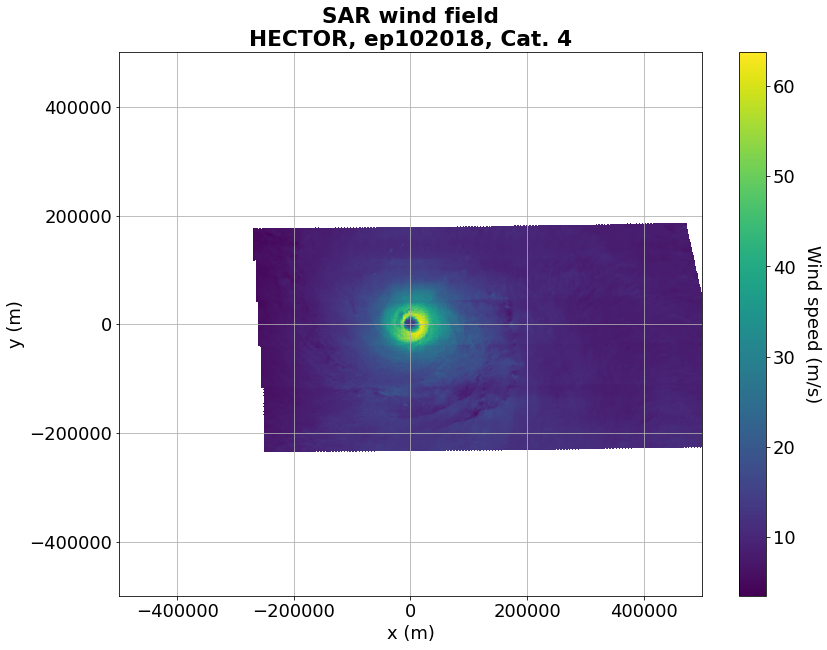

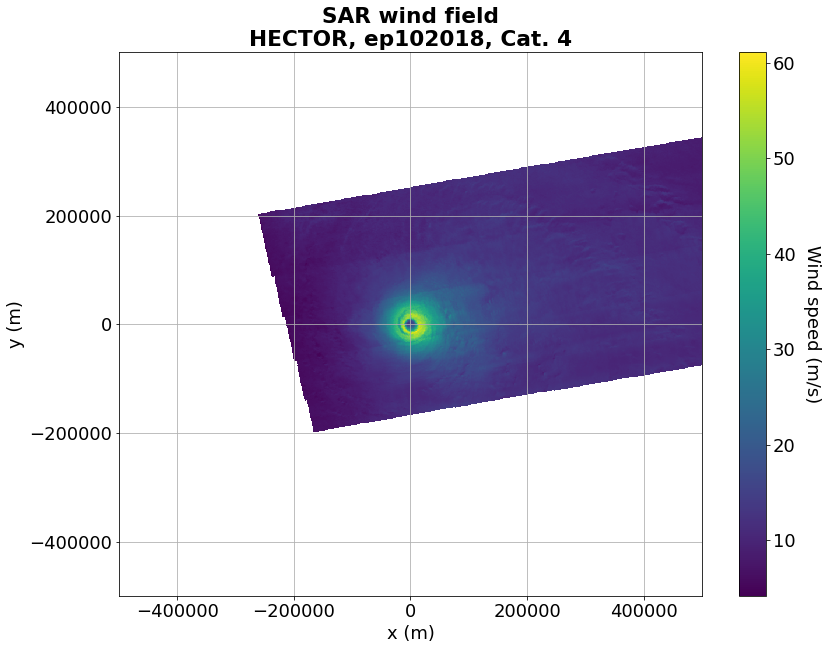

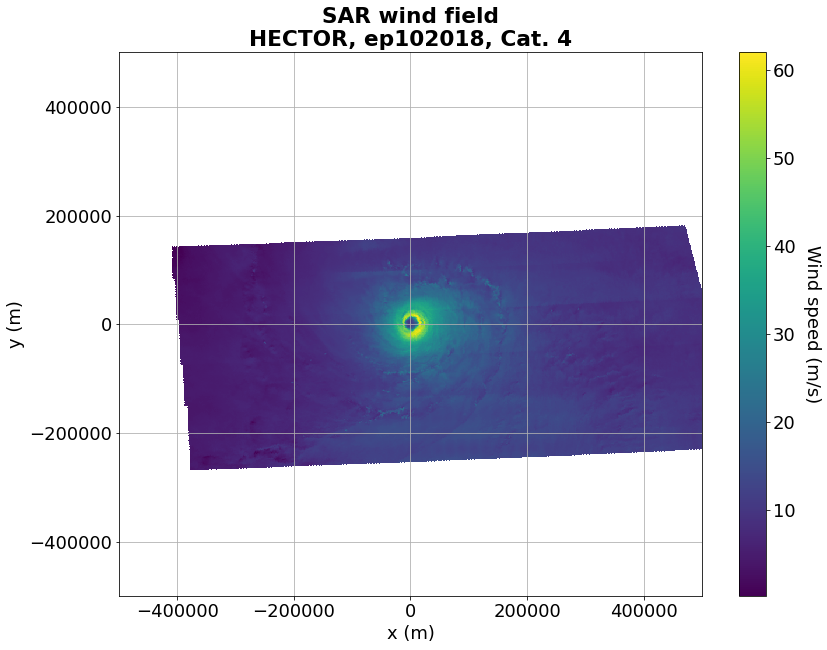

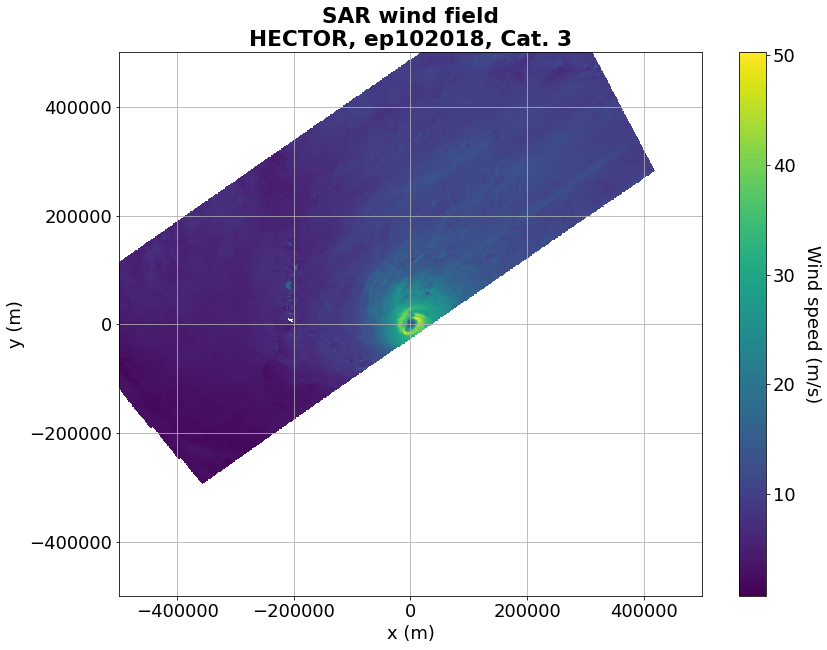

In [4]:
### FIND ALL TIME INDEXES FROM NAME AND PLOT ALL CORRESPONDING OBSERVATIONS
def find_time_idx(ds_all, storm_name):
    return np.where(ds_all['storm_name']==storm_name)[0]

storm_name = 'HECTOR'
print('Indexes for %s: '%storm_name, find_time_idx(ds_all, storm_name))
for time_idx in find_time_idx(ds_all, storm_name):
    plot_wind_field(ds_all, time_idx)

CPU times: user 8.73 s, sys: 1.66 s, total: 10.4 s
Wall time: 2.29 s


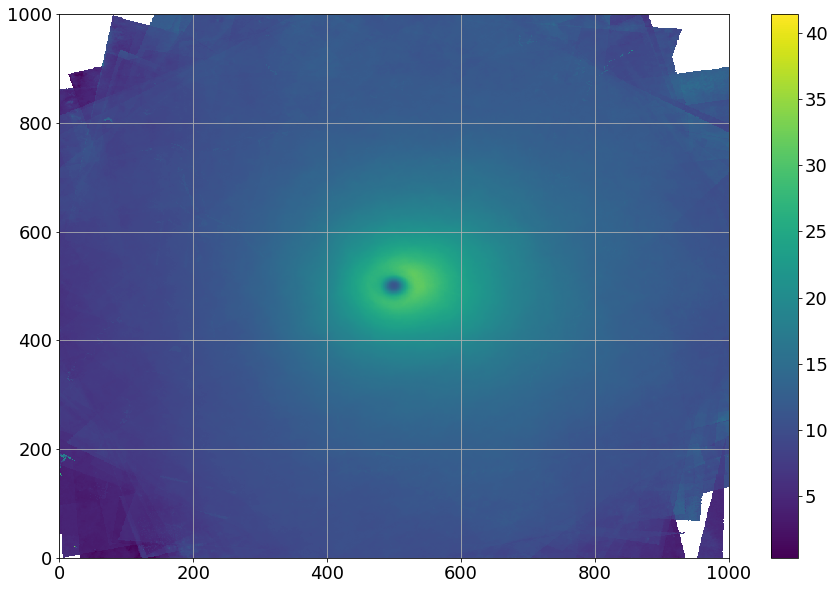

In [5]:
%%time
### DISPLAY AVERAGE WIND FIELD
mean_ws = np.nanmean(ds_all['wind_speed'], axis=0)
plt.pcolormesh(mean_ws);plt.grid();plt.colorbar()

Cat. 0 = 92
Cat. 1 = 82
Cat. 2 = 41
Cat. 3 = 55
Cat. 4 = 54
Cat. 5 = 17


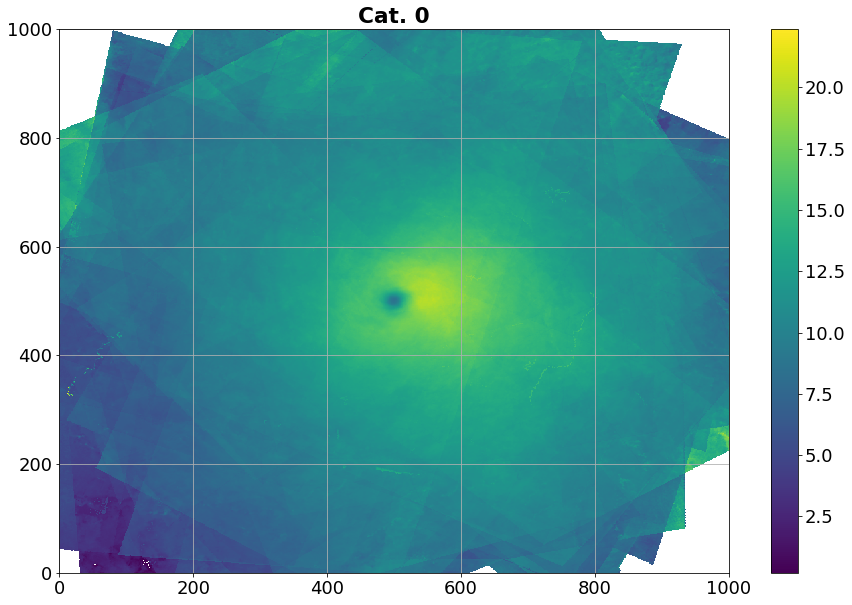

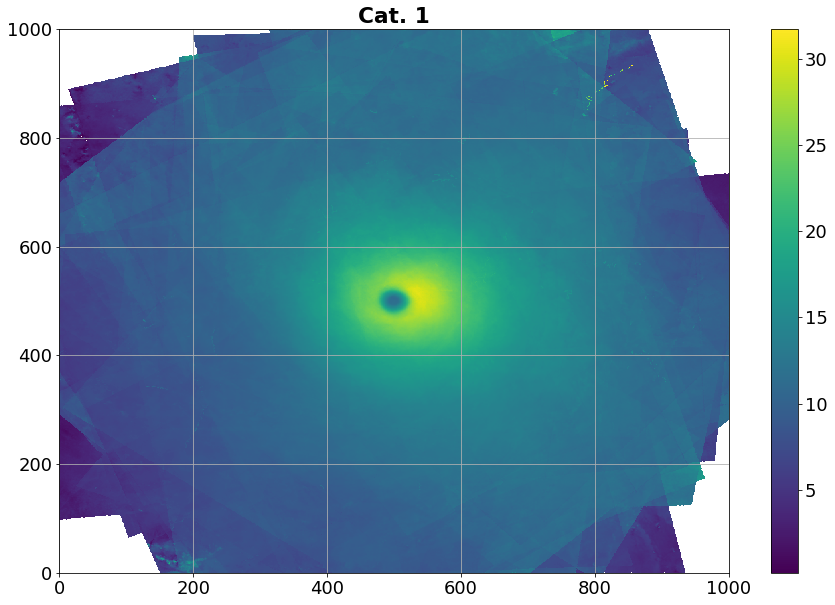

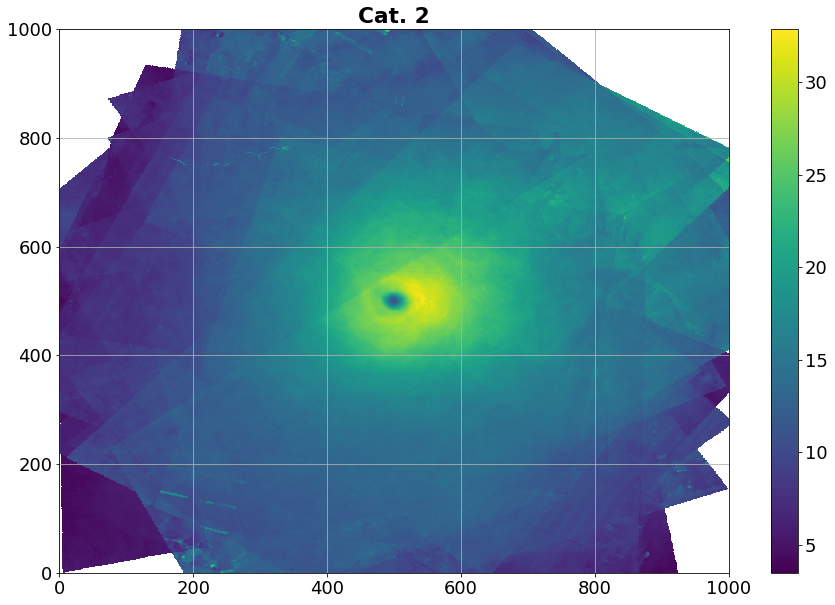

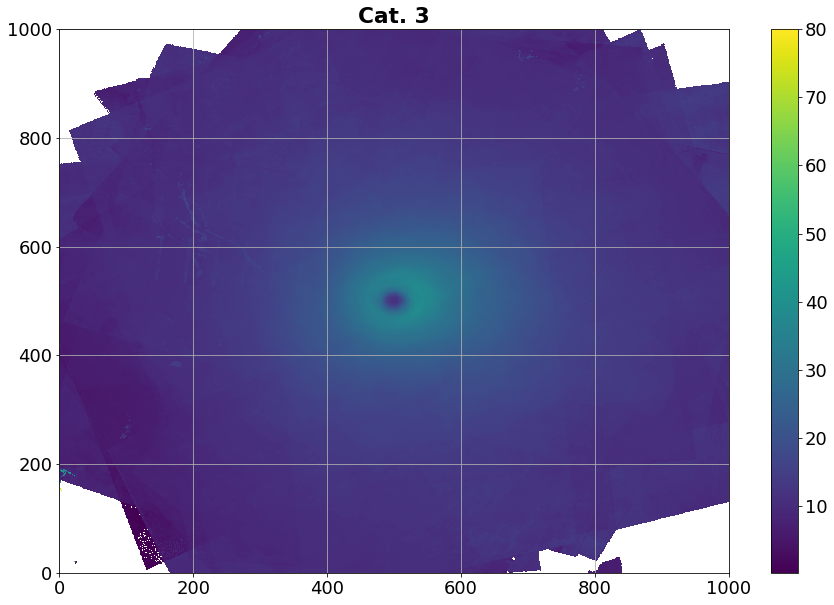

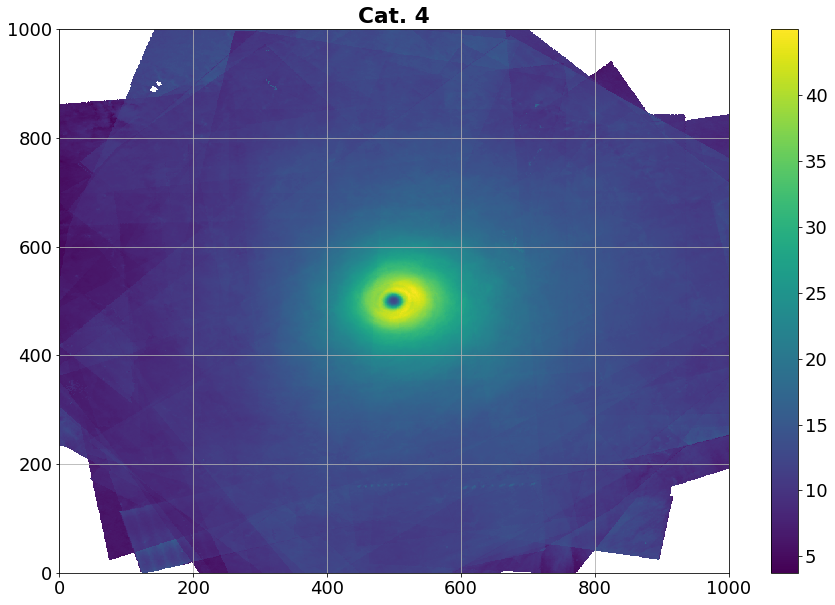

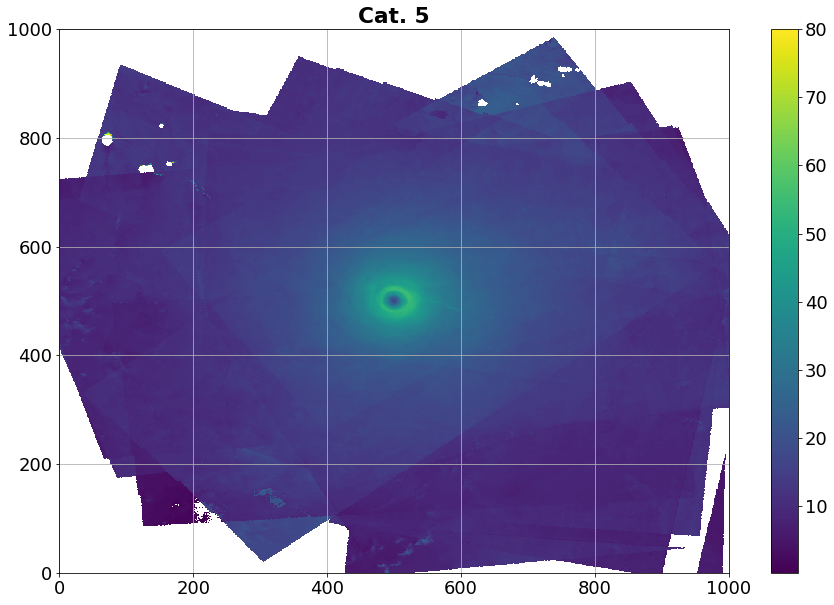

<Figure size 1080x720 with 0 Axes>

In [6]:
### DISPLAY MEAN BY CATEGORY
# Compute
mean_ws_by_cat = []
for cat, ds_cat in ds_all.groupby('cat'):
    print('Cat. %i ='%cat, ds_cat.dims['time'])
    mean_ws_by_cat.append(np.nanmean(ds_cat['wind_speed'], axis=0))

# Display
for cat, mean_ws in enumerate(mean_ws_by_cat):
    plt.title('Cat. %i'%cat, weight='bold')
    plt.pcolormesh(mean_ws);plt.grid();plt.colorbar()
    plt.show();plt.clf()

In [127]:
### COVARIANCE OF FIRST n FIELDS
n_total = len(ds_all['time'])
n       = 50 # nb of samlpes
dsn     = ds_all.isel(time=slice(0, n))

# Put on lower resolution grid
resolution = 25 # in pixels (here = km)
xHR, yHR   = np.meshgrid(dsn['x'], dsn['y'])
xLR, yLR   = np.meshgrid(dsn['x'][::resolution], dsn['y'][::resolution])

# Interpolate to lower resolution and concatenate
# Initialize
ds_wsHR    = np.array(dsn.isel(time=0)['wind_speed']) # convert to np.array
conc       = griddata((xHR.flatten(), yHR.flatten()), ds_wsHR.flatten(), (xLR, yLR), method='nearest')
conc       = np.expand_dims(conc, axis=0)
# Loop
for i in tqdm(range(n - 1)):
    i         += 1
    ds_wsHR    = np.array(dsn.isel(time=i)['wind_speed']) # convert to np.array
    new        = griddata((xHR.flatten(), yHR.flatten()), ds_wsHR.flatten(), (xLR, yLR), method='nearest')
    new        = np.expand_dims(new, axis=0)
    conc       = np.concatenate((conc, new), axis=0)   
print('Shape of concatenated array: ', conc.shape)

# Flatten
flat = np.reshape(conc, (conc.shape[0], conc.shape[1] * conc.shape[2]))
print('Shape of flattened array: ', flat.shape)

100%|█████████████████████████████████████████| 340/340 [01:08<00:00,  4.93it/s]

Shape of concatenated array:  (341, 40, 40)
Shape of flattened array:  (341, 1600)


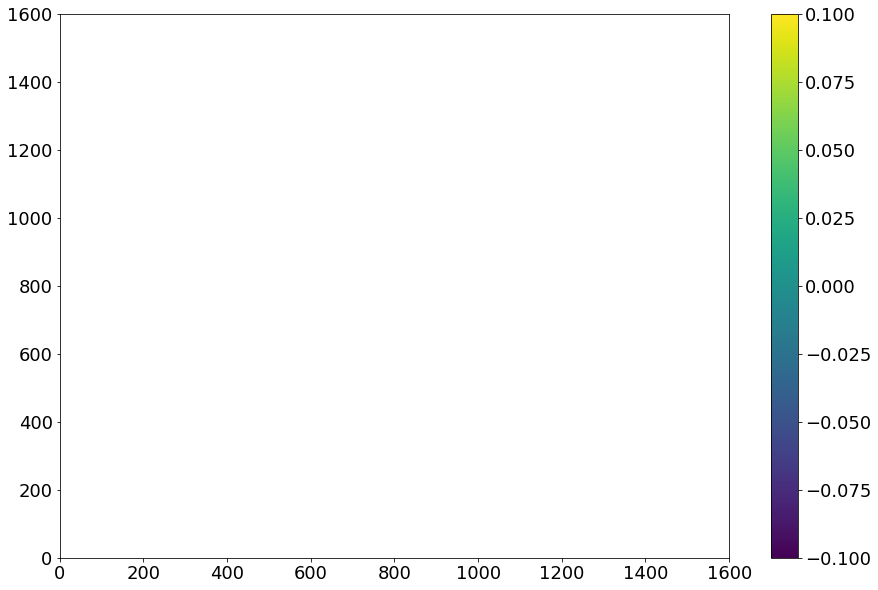

In [128]:
# Compute covariance USING DASK
# CAVEAT: how NaNs are handled? 
z       = da.array.cov(flat, rowvar=False)
cov_mat = z.compute()
plt.pcolormesh(cov_mat);plt.colorbar()

Shape of gap: (341, 1600)


100%|█████████████████████████████████████████| 340/340 [02:55<00:00,  1.94it/s]


Shape of product:  (341, 1600, 1600)
Shape of covariance matrix:  (1600, 1600)


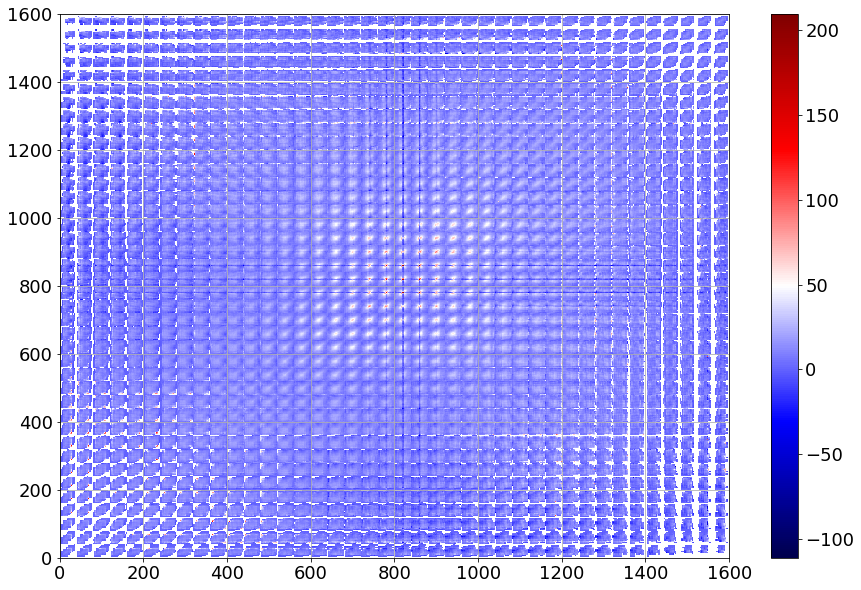

In [129]:
# Compute covariance handling NaNs
gap     = flat - np.nanmean(flat, axis=0) # 10 samples of x - E(x) transposed
print('Shape of gap:', gap.shape)

# Initialize
x_Ex    = np.expand_dims(gap[0, :], axis=1)
product = np.dot(x_Ex, np.transpose(x_Ex))
product = np.expand_dims(product, axis=0)
# Loop
for i in tqdm(range(n - 1)):
    x_Ex    = np.expand_dims(gap[i, :], axis=1)
    new     = np.dot(x_Ex, np.transpose(x_Ex))
    new     = np.expand_dims(new, axis=0)
    product = np.concatenate((product, new), axis=0)
print('Shape of product: ', product.shape)

# Compute average
# i.e E(product) where product = (x - E(x)).(x - E(x)).T
cov_mat = np.nanmean(product, axis=0)
print('Shape of covariance matrix: ', cov_mat.shape)

# Plot
cov_mat.shape
plt.pcolormesh(cov_mat, cmap='seismic');plt.colorbar();plt.grid()

In [ ]:
### COVARIANCE BY CATEGORY
# Compute
mean_ws_by_cat = []
for cat, ds_cat in ds_all.groupby('cat'):
    print('Cat. %i ='%cat, ds_cat.dims['time'])
    mean_ws_by_cat.append(np.nanmean(ds_cat['wind_speed'], axis=0))

# Display
for cat, mean_ws in enumerate(mean_ws_by_cat):
    plt.title('Cat. %i'%cat, weight='bold')
    plt.pcolormesh(mean_ws);plt.grid();plt.colorbar()
    plt.show();plt.clf()

In [ ]:
### DISPLAY ALL SOUTHERN HEMISPHERE TCs
# ds2 = ds_all.where(ds_all['lat'][:, 499, 499] < 0)
# ds2['wind_speed'][:, :, :].values
# for time_idx in range(len(ds2.time)):
#     if ds_all['lat'][time_idx, 499, 499] < 0:
#         print(time_idx)
#         plot_wind_field(ds_all, time_idx=time_idx)

In [ ]:
### TODO: Interpolate on regular (r, th) grid (OPTIONAL)
### Shift SH TCs ==> Already done
### REMOVE outlier pixels 
### Questions: how many cat.0, cat.1 etc.. do we have? In which basins? Wind field max? Wind speed mean? Average wind field etc...? Average wind field per category? 1D profile? 
### Covariance matrix? 1D covariance? 

In [ ]:
import gcsfs

In [ ]:
fs = gcsfs.GCSFileSystem(project='alert-ground-261008', token='anon', access='read_only')
fs.ls('project10_tc_sar')

In [ ]:
fs     = gcsfs.GCSFileSystem(token='anon', access='read_only')
mapper = fs.get_mapper('project10_tc_sar/tc_sar_data.zarr')
ds     = xr.open_zarr(mapper, consolidated=True)

In [ ]:
fs = gcsfs.GCSFileSystem(project='ds2class', token='anon', access='read_only')
fs.ls('project10_tc_sar')